## Segment earthquake + no-quake data into 15s windows for classification

Segment data into richter classes. 

Normalize across *both* time and stations

Convert accelerations to log(accelerations)

In [1]:
import sys
sys.path.append("../utils/.")

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# tf.random.set_random_seed(13)

from utils import *
import copy 


In [3]:
data_path = '../data/acc/compressed/full_data.npy'
save_path = "../data/histStat_norm_class/"

if not os.path.exists(save_path):
    os.makedirs(save_path)

STEP = 1
future_target = 10
past_history = 15


## The Ridgecrest Dataset
This notebook uses a earthquake dataset from Ridgecrest, collected from July to September of 2019.
There are several thousand earthquakes during this time period, which were collected at anywhere from 16-30 stations.

35679
-0.49 7.1
0 5


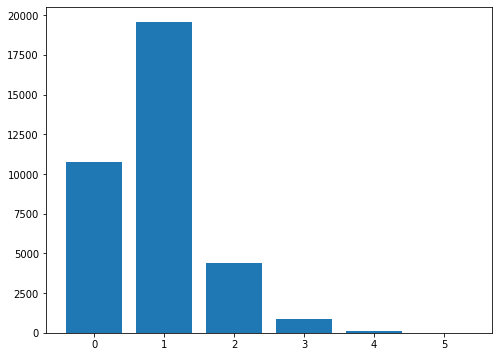

In [4]:
from sklearn.utils.class_weight import compute_class_weight

richters_path = "../data/metadata/richters.npy"
richters = np.load(richters_path)
print(len(richters))
print(min(richters), max(richters))

classes = [0, 1, 2, 3]
richters_classes = np.floor(richters).astype(int) 
richters_classes[richters_classes >= 5] = 5
richters_classes[richters_classes <= 0] = 0

print(richters_classes.min(), richters_classes.max())

unique, counts = np.unique(richters_classes, return_counts=True)
plt.bar(unique, counts)
plt.show()

In [5]:
#Swap axes
dataset = np.load(data_path)
print("Before: ", dataset.shape)
dataset = dataset.swapaxes(1, -1)
print("After: ", dataset.shape)


TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)

## Shuffle dataset and richter classes
dataset, richters_classes = shuffle_together(dataset, richters_classes, seed=10)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


### Important: Convert to logarithms

Richter scale maps log(mag) $\to$ scale numbers 

Due to random seed, freeze order of dataset and richter_classes

In [6]:
log_data = np.log(dataset + 1e-6) #const to prevent div by 0 bugs

In [7]:
largest_idxs_train = np.where(richters_classes[:TRAIN_SPLIT_IDX] >= unique[-1])
largest_idxs_val = np.where(richters_classes[TRAIN_SPLIT_IDX:] >= unique[-1])

print(largest_idxs_train, largest_idxs_val)

(array([11660, 13108, 19117, 24685]),) (array([5385, 6250]),)


In [8]:
richters_classes[:TRAIN_SPLIT_IDX].max()

5

In [9]:
## Normalization over 60-sec intervals
# dataset dims are (N, T, dim)
data_mean = np.mean(log_data, axis = (1, 2), keepdims=True) #(N, 1, 1)

data_var = np.linalg.norm(log_data - data_mean, axis = (1, 2), keepdims=True) # (N,1,1) 

#Add some epsilon to make the divide by zero var work
data_var[data_var == 0] = 1

dataset_normalized = (dataset - data_mean)/data_var #(N, T, dim)

train_data = copy.deepcopy(dataset_normalized[:TRAIN_SPLIT_IDX])
val_data = copy.deepcopy(dataset_normalized[TRAIN_SPLIT_IDX:])
train_labels = richters_classes[:TRAIN_SPLIT_IDX]
val_labels = richters_classes[TRAIN_SPLIT_IDX:]

x_train_norm, _, q_idxs_train = multivariate_data(train_data, past_history,
                                               future_target, STEP,
                                               single_step=False,
                                                 return_indices=True
                                                 )
x_val_norm, _, q_idxs_val = multivariate_data(val_data, past_history,
                                               future_target, STEP,
                                               single_step=False,
                                            return_indices=True
                                             )



print([(tensor.max(), tensor.min()) for tensor in [x_train_norm, x_val_norm]])


np.save(os.path.join(save_path, "X_train_norm60.npy"), x_train_norm)
np.save(os.path.join(save_path, "X_val_norm60.npy"), x_val_norm)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[(0.8902501394608775, 0.06663559279150762), (0.88376576414023, 0.0375788290841515)]


In [13]:
## Save Richter 5-7 earthquakes FROM VAL SET

large_tensors = log_data[TRAIN_SPLIT_IDX:][largest_idxs_val]

x_val_norm_large, y_val_norm_large = multivariate_data(copy.deepcopy(large_tensors), past_history,
                                               future_target, STEP,
                                               single_step=False)

print(x_val_norm_large.max(), x_val_norm_large.min())
np.save(os.path.join(save_path, "large_X_val_norm.npy"), x_val_norm_large)
np.save(os.path.join(save_path, "large_y_val_norm.npy"), y_val_norm_large)
print(len(x_val_norm_large))

0.9675964175391135 -11.93486834939728
70


In [25]:
x_train_single, _, q_idxs_train = multivariate_data(log_data[:TRAIN_SPLIT_IDX],past_history,
                                                   future_target, STEP,
                                                   single_step=False,
                                                  return_indices=True
                                                          )
x_val_single, _, q_idxs_val = multivariate_data(log_data[TRAIN_SPLIT_IDX:], past_history,
                                               future_target, STEP,
                                               single_step=False,
                                                return_indices=True
                                                      )

y_train_labels = np.take(train_labels, q_idxs_train)
y_val_labels = np.take(val_labels, q_idxs_val)

# print(y_single.shape, x_single.shape)
# x_train_single, x_val_single, y_train_single, y_val_single = train_test_split(x_single, y_single, test_size=.2, random_state=13)
print(x_train_single.shape, x_val_single.shape)

(999005, 15, 15) (249760, 15, 15)


In [26]:
np.save(os.path.join(save_path, "y_train_labels.npy"), y_train_labels)
np.save(os.path.join(save_path, "y_val_labels"), y_val_labels)

In [27]:
print(x_train_single.min(), x_train_single.max())

print(x_val_single.min(), x_val_single.max())


-13.815510557964274 -0.06506396520283543
-13.815510557964274 0.9675964175391135


In [28]:
np.save(os.path.join(save_path, "X_train_unnorm.npy"), x_train_single)
np.save(os.path.join(save_path, "X_val_unnorm.npy"), x_val_single)


# Normalization over 15-sec history

In [57]:
# """
# Effect of different eps values
# """

# train_means, train_vars = [], []
# val_means, val_vars = [], []

# for i in range(1, 15):
#     eps = 10**(-i)
#     x_train_single_clone = copy.deepcopy(x_train_single)
#     x_val_single_clone = copy.deepcopy(x_val_single)
#     y_train_single_clone = copy.deepcopy(y_train_single)
#     y_val_single_clone = copy.deepcopy(y_val_single)

#     data_mean_train = np.mean(x_train_single_clone, axis = 1, keepdims=True)

#     # print(data_mean_train.max(), data_mean_train.min())
#     data_var_train = np.linalg.norm(x_train_single_clone - data_mean_train, axis=1, keepdims=True)
#     data_var_train[data_var_train < eps] = 1

#     # print(data_var_train.max(), data_var_train.min())
#     x_train_single_clone = (x_train_single_clone - data_mean_train)/data_var_train
#     y_train_single_clone = (y_train_single_clone - data_mean_train)/data_var_train


#     data_mean_val = np.mean(x_val_single_clone, axis = 1, keepdims=True)
#     data_var_val = np.linalg.norm(x_val_single_clone - data_mean_val, axis=1, keepdims=True)
#     data_var_val[data_var_val < eps] = 1

#     x_val_single_clone = (x_val_single_clone - data_mean_val)/data_var_val
#     y_val_single_clone = (y_val_single_clone - data_mean_val)/data_var_val
    
#     train_means.append(x_train_single_clone.mean())
#     train_vars.append(x_train_single_clone.std()**2)
#     val_means.append(x_val_single_clone.mean())
#     val_vars.append(x_val_single_clone.std()**2)

# plt.plot([i for i in range(1, 15)], train_means)
# plt.plot([i for i in range(1, 15)], val_means)
# plt.title("Means")
# plt.show()

# plt.plot([i for i in range(1, 15)], train_vars)
# plt.plot([i for i in range(1, 15)], val_vars)
# plt.title("Vars")
# plt.show()

In [13]:
eps = 1e-7
"""
Normalizing using 15-sec history across TIME ONLY
"""
data_mean_train = np.mean(x_train_single, axis = 1, keepdims=True)
data_std_train = x_train_single.std(axis=1, keepdims=True)
print(data_std_train.shape)
data_std_train[data_std_train < eps] = 1

x_train_single = (x_train_single - data_mean_train)/data_std_train

print(x_val_single.max(), x_val_single.min())

data_mean_val = np.mean(x_val_single, axis = 1, keepdims=True)
data_std_val = x_val_single.std(axis=1 , keepdims=True)
print(data_std_val.max(), data_std_val.min())
data_std_val[data_std_val < eps] = 1

x_val_single = (x_val_single - data_mean_val)/data_std_val




(999005, 1, 15)
0.9675964175391135 -13.815510557964274
5.196847680528816 0.0


In [16]:
print(x_train_single.max(), x_train_single.min())
print(x_val_single.max(), x_val_single.min())

3.741657386774012 -3.740367715081277
3.741657386773947 -3.7297080085035246


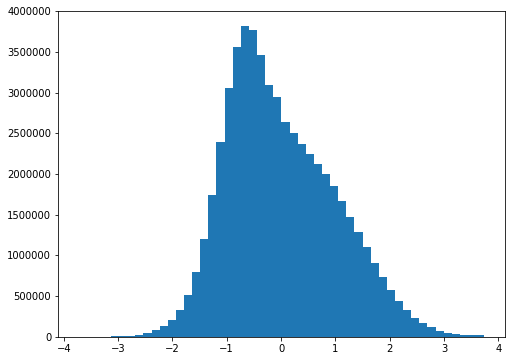

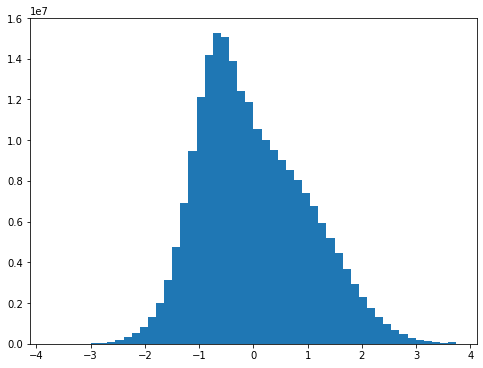

In [17]:
plt.hist(x_val_single.flatten(), bins=50)
plt.show()

plt.hist(x_train_single.flatten(), bins=50)
plt.show()

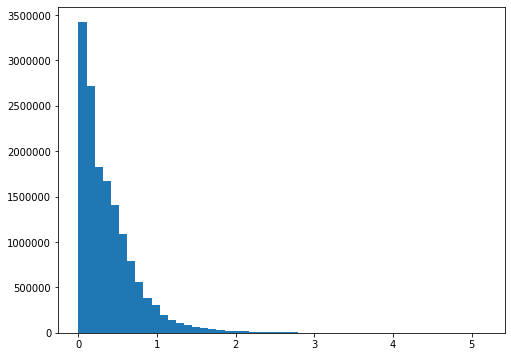

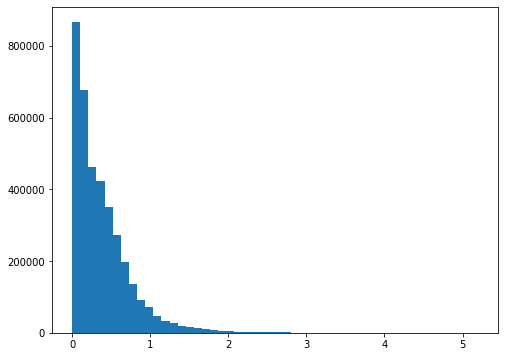

In [18]:
plt.hist(data_std_train.flatten(), bins=50)
plt.show()

plt.hist(data_std_val.flatten(), bins=50)
plt.show()

In [19]:
x_train_single.shape, x_val_single.shape, 

((999005, 15, 15), (249760, 15, 15))

In [20]:
np.save(os.path.join(save_path, "X_train_histnorm.npy"), x_train_single)
np.save(os.path.join(save_path, "X_val_histnorm.npy"), x_val_single)

np.save(os.path.join(save_path, "mean_train_histnorm.npy"), data_mean_train)
np.save(os.path.join(save_path, "std_train_histnorm.npy"), data_std_train)
np.save(os.path.join(save_path, "mean_val_histnorm.npy"), data_mean_val)
np.save(os.path.join(save_path, "std_val_histnorm.npy"), data_std_val)

In [30]:
import json

config = dict(zip(["data_path", "past_history", "STEP", "future_target"], \
                  [data_path, past_history, STEP, future_target]))

with open(os.path.join(save_path, "config.json"), 'w') as json_file:
    json.dump(config, json_file)

In [ ]:
print(x_train_single.max())